# Imports

In [2]:
import tensorflow as tf
import cv2
import json
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from keras.utils import load_img
from PIL import Image
from tqdm import tqdm
import os

## GPU Memory Limit

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [4]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Gender Detection

In [5]:
image_paths = []
age_labels = []
gender_labels = []
BASE_DIR = '../face_gender_age_detection/UTKFace/UTKFace'

for file in tqdm(os.listdir(BASE_DIR)):
    image_path = os.path.join(BASE_DIR, file)
    age_gender = file.split('_')
    age = int(age_gender[0])
    gender = int(age_gender[1])
    image_paths.append(image_path)
    age_labels.append(age)
    gender_labels.append(gender)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 23708/23708 [00:00<00:00, 318917.77it/s]


In [6]:
len(image_paths), len(age_labels), len(gender_labels)

(23708, 23708, 23708)

In [7]:
gender_dict = {0:'Male', 1:'Female'}

In [9]:
df = pd.DataFrame()
df['image'], df['age'], df['gender'] = image_paths, age_labels, gender_labels
df.head()

,image,age,gender
0,../face_gender_age_detection/UTKFace/UTKFace\1...,100,0
1,../face_gender_age_detection/UTKFace/UTKFace\1...,100,0
2,../face_gender_age_detection/UTKFace/UTKFace\1...,100,1
3,../face_gender_age_detection/UTKFace/UTKFace\1...,100,1
4,../face_gender_age_detection/UTKFace/UTKFace\1...,100,1


In [10]:
under4s = []

for i in range(len(df)):
    if df['age'].iloc[i] <= 4:
        under4s.append(df.iloc[i])
under4s = pd.DataFrame(under4s)
under4s = under4s.sample(frac=0.3)

df = df[df['age'] > 4]

df = pd.concat([df, under4s], ignore_index = True)

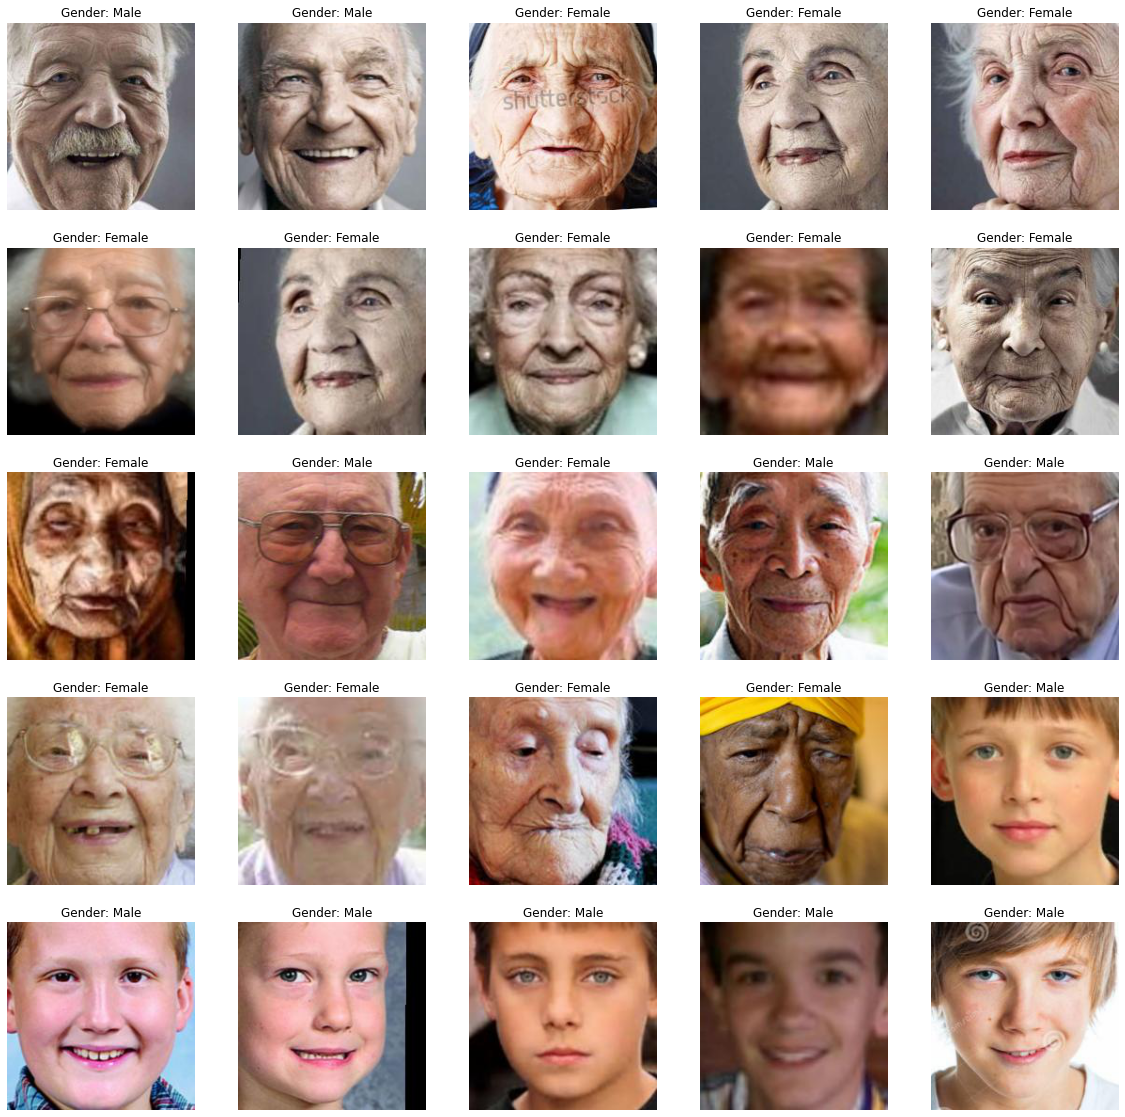

In [11]:
# to display grid of images
plt.figure(figsize=(20, 20))
files = df.iloc[0:25]
for index, file, age, gender in files.itertuples():
    plt.subplot(5, 5, index + 1)
    img = load_img(file)
    img = np.array(img)
    plt.imshow(img)
    plt.title(f"Gender: {gender_dict[gender]}")
    plt.axis('off')

In [12]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.2, shuffle=True)

In [13]:
X_train = []
for image in tqdm(train['image']):
    img = load_img(image)
    img = img.resize((120, 120), Image.Resampling.LANCZOS)
    img = np.array(img)
    X_train.append(img)

X_train = np.array(X_train)
# ignore this step if using RGB
# X_train = X_train.reshape(len(X_train), 120, 120, 1)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 17752/17752 [00:22<00:00, 805.45it/s]


In [14]:
X_train.shape

(17752, 120, 120, 3)

In [15]:
X_train = X_train/255.0 # Normalizing the images

In [16]:
y_train_gender = np.array(train['gender'])
y_train_gender.shape

(17752,)

In [17]:
X_test = []
for image in tqdm(test['image']):
    img = load_img(image)
    img = img.resize((120, 120), Image.Resampling.LANCZOS)
    img = np.array(img)
    X_test.append(img)

X_test = np.array(X_test)
# ignore this step if using RGB
# X_test = X_test.reshape(len(X_test), 120, 120, 1)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4439/4439 [00:05<00:00, 810.20it/s]


In [18]:
X_test = X_test/255.0 # Normalizing the images

In [19]:
y_test_gender = np.array(test['gender'])

In [20]:
input_shape = (120, 120, 3)

In [21]:
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input

In [22]:
inputs = Input((input_shape))
# convolutional layers
conv_1 = Conv2D(32, kernel_size=(3, 3), activation='relu') (inputs)
maxp_1 = MaxPooling2D(pool_size=(2, 2)) (conv_1)
conv_2 = Conv2D(64, kernel_size=(3, 3), activation='relu') (maxp_1)
maxp_2 = MaxPooling2D(pool_size=(2, 2)) (conv_2)
conv_3 = Conv2D(128, kernel_size=(3, 3), activation='relu') (maxp_2)
maxp_3 = MaxPooling2D(pool_size=(2, 2)) (conv_3)
conv_4 = Conv2D(256, kernel_size=(3, 3), activation='relu') (maxp_3)
maxp_4 = MaxPooling2D(pool_size=(2, 2)) (conv_4)

flatten_gender = Flatten() (maxp_4)

# fully connected layers
dense_1 = Dense(128, activation='relu') (flatten_gender)
dropout_1 = Dropout(0.3) (dense_1)
output_1 = Dense(1, activation='sigmoid', name='gender_out') (dropout_1)

model_gender = Model(inputs=[inputs], outputs=[output_1])

model_gender.compile(loss=['binary_crossentropy', 'mae'], optimizer='adam', metrics=['accuracy'])

In [23]:
history_gender = model_gender.fit(x=X_train, y=np.array(y_train_gender), batch_size=64, epochs=9)
model_gender.save('gendermodel')
#model_gender = tf.keras.models.load_model('gendermodel')

Epoch 1/9
278/278 [==============================] - 19s 28ms/step - loss: 0.4570 - accuracy: 0.7747
Epoch 2/9
278/278 [==============================] - 7s 27ms/step - loss: 0.2974 - accuracy: 0.8736
Epoch 3/9
278/278 [==============================] - 8s 27ms/step - loss: 0.2573 - accuracy: 0.8957
Epoch 4/9
278/278 [==============================] - 7s 27ms/step - loss: 0.2328 - accuracy: 0.9062
Epoch 5/9
278/278 [==============================] - 8s 28ms/step - loss: 0.2112 - accuracy: 0.9162
Epoch 6/9
278/278 [==============================] - 7s 27ms/step - loss: 0.1899 - accuracy: 0.9274
Epoch 7/9
278/278 [==============================] - 7s 27ms/step - loss: 0.1757 - accuracy: 0.9332
Epoch 8/9
278/278 [==============================] - 8s 27ms/step - loss: 0.1575 - accuracy: 0.9406
Epoch 9/9
278/278 [==============================] - 8s 28ms/step - loss: 0.1485 - accuracy: 0.9417


INFO:tensorflow:Assets written to: gendermodel\assets


INFO:tensorflow:Assets written to: gendermodel\assets


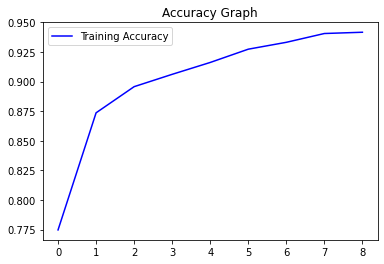

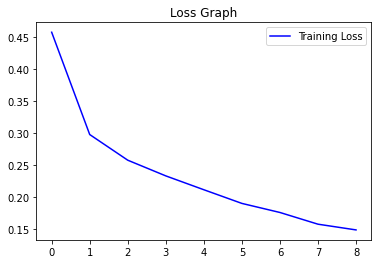

In [24]:
# plot results for gender
acc = history_gender.history['accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

loss = history_gender.history['loss']

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

In [25]:
X_test.shape

(4439, 120, 120, 3)

In [26]:
pred_gender = model_gender.predict(X_test)

139/139 [==============================] - 1s 5ms/step


In [28]:
X_test[0].shape, np.array(pred_gender).shape

((120, 120, 3), (4439, 1))

In [29]:
pred_df = pd.DataFrame()
pred_df['image'], pred_df['gender'] = test['image'], pred_gender.reshape(4439, )
pred_df = pred_df.reset_index(drop=True)
pred_df.head()

,image,gender
0,../face_gender_age_detection/UTKFace/UTKFace\5...,9.900373e-01
1,../face_gender_age_detection/UTKFace/UTKFace\4...,2.995488e-11
2,../face_gender_age_detection/UTKFace/UTKFace\3...,5.947056e-01
3,../face_gender_age_detection/UTKFace/UTKFace\3...,7.282475e-04
4,../face_gender_age_detection/UTKFace/UTKFace\1...,9.957218e-01


In [30]:
correct_gender = 0
correct_age = 0
count = 0
pred_age_list = []
pred_gender_list = []

for img in tqdm(X_test):
    if y_test_gender[count] == round(pred_gender[count][0]):
        correct_gender += 1
        
    count += 1

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 4439/4439 [00:00<00:00, 403434.79it/s]


In [31]:
correct_gender, (len(y_test_gender) - correct_gender)

(4167, 272)

In [32]:
gender_pred_accuracy = (correct_gender * 100) / len(y_test_gender)
gender_pred_accuracy

93.87249380491102

In [33]:
pred_df

,image,gender
0,../face_gender_age_detection/UTKFace/UTKFace\5...,9.900373e-01
1,../face_gender_age_detection/UTKFace/UTKFace\4...,2.995488e-11
2,../face_gender_age_detection/UTKFace/UTKFace\3...,5.947056e-01
3,../face_gender_age_detection/UTKFace/UTKFace\3...,7.282475e-04
4,../face_gender_age_detection/UTKFace/UTKFace\1...,9.957218e-01
...,...,...
4434,../face_gender_age_detection/UTKFace/UTKFace\8...,4.906299e-01
4435,../face_gender_age_detection/UTKFace/UTKFace\1...,9.137795e-03
4436,../face_gender_age_detection/UTKFace/UTKFace\5...,6.074031e-05
4437,../face_gender_age_detection/UTKFace/UTKFace\3...,9.974566e-01


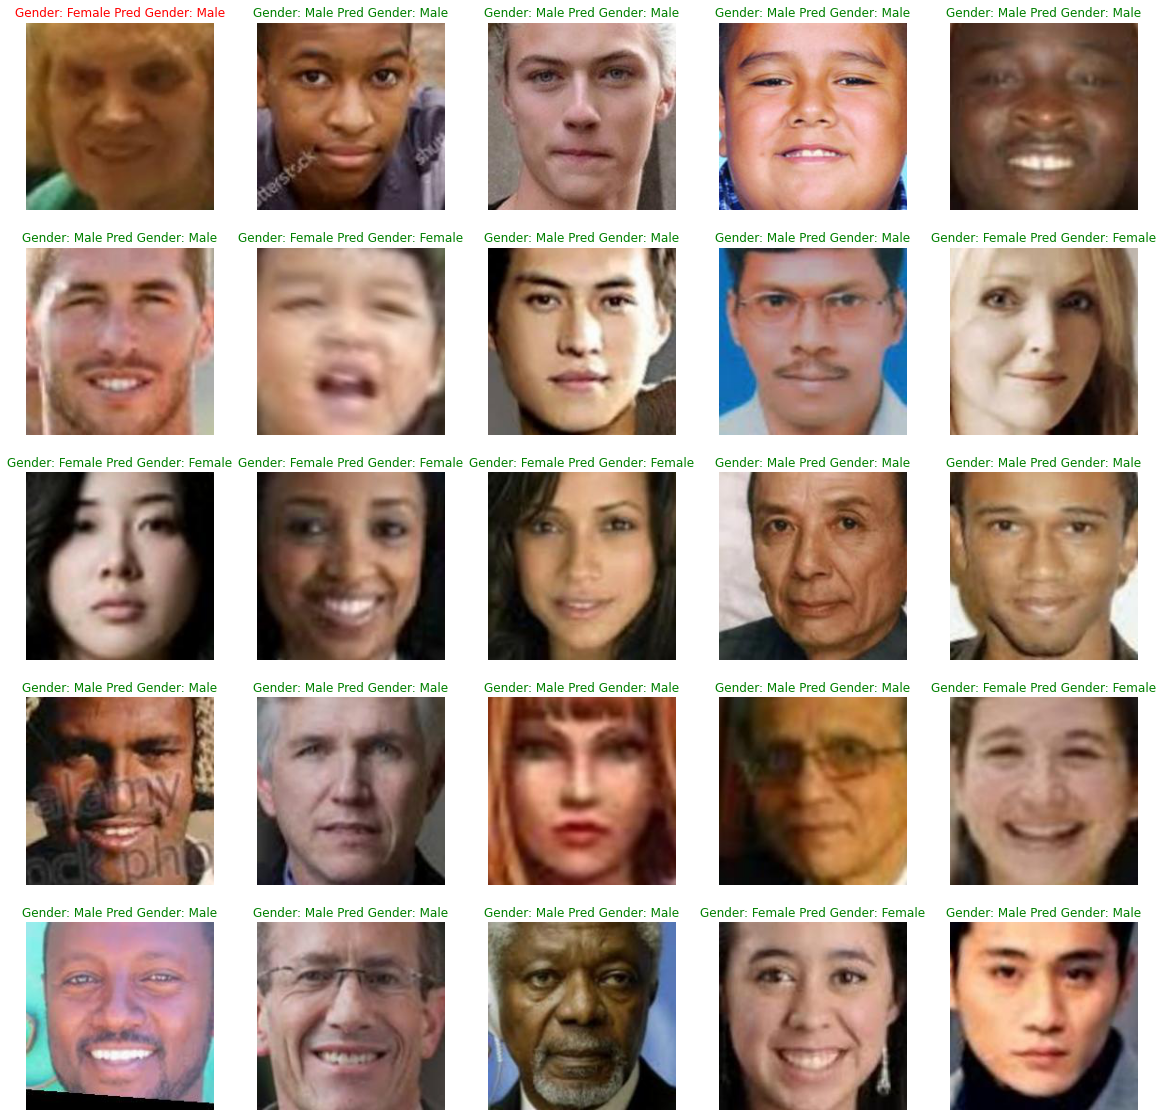

In [36]:
# to display grid of images
plt.figure(figsize=(20, 20))
files = test.reset_index(drop=True).iloc[25:50]
for index, file, age, gender in files.itertuples():
    plt.subplot(5, 5, (index % 25) + 1)
    img = load_img(file)
    img = np.array(img)
    plt.imshow(img)
    plt.title(f"Gender: {gender_dict[gender]} Pred Gender: {gender_dict[round(pred_df['gender'][index])]}", color=("green" if gender_dict[gender] == gender_dict[round(pred_df['gender'][index])] else "red"))
    plt.axis('off')